<a href="https://colab.research.google.com/github/ComputationalAgingLab/MethylationClock/blob/main/age_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Моделирование процессов старения с помощью данных метилирования генома человека

## Описание данных

Датасет с данными о метилировании ДНК GSE87571 в 476 366 сайта по всему геному белых кровяных телец из когорты населения (N = 421) в возрасте от 14 до 94 лет, количество образцов составляет 732.

Адрес датасета на сайте GEO
https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE87571

## Полученные результаты

Были обучены и две модели машинного обучения прогнозирующие возраст человека по данным метилирования, качество моделей оценненое на тестовом наборе данных по метрике MAE (средняя абсолютная ошибка) составило:
* модель для женщин: MAE = 2.93
* модель для мужчин: MAE = 2.97

Был проведен анализ важности признаков и выделены группы генов сайты метилирования которых вносят наибольшие вклады в оценки возраста моделей.

<img src = "https://raw.githubusercontent.com/ComputationalAgingLab/MethylationClock/main/final_elastic_net_weights_by_groups.png"/>

In [ ]:
from google.colab import drive

import os
import time
import sys
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

import joblib

In [ ]:
# Подключаемся к диску
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# укажем путь к корневой папке с данными
if os.path.isdir('/content/drive/Shareddrives/OpenLabData/Methylation/GSE87571/preprocessed'):
    
    path_root_dir = '/content/drive/Shareddrives/OpenLabData'
    path_main_dir = '/content/drive/Shareddrives/OpenLabData/Methylation/GSE87571'
else: 
    raise Exception('Задайте путь к корневой папке с файлами')

## Загрузка данных с уровнями метилирования в CG-islands

In [ ]:
data_joined = pd.read_csv(
    path_main_dir + "/preprocessed/data_methylation.csv",
    index_col = 0
    )

display(data_joined.shape)
display(data_joined.head())
display(data_joined.tail())

(485512, 732)

,X1,X10,X100,X101,X102,X103,X104,X105,X106,X107,X108,X109,X11,X110,X111,X112,X113,X114,X115,X116,X117,X118,X119,X12,X120,X121,X122,X123,X124,X125,X126,X127,X128,X129,X13,X130,X131,X132,X133,X134,...,X722,X723,X724,X725,X726,X727,X728,X729,X73,X730,X731,X732,X74,X75,X76,X77,X78,X79,X8,X80,X81,X82,X83,X84,X85,X86,X87,X88,X89,X9,X90,X91,X92,X93,X94,X95,X96,X97,X98,X99
ID_REF,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
cg00050873,0.824023,NaN,NaN,NaN,NaN,0.858559,NaN,0.878558,NaN,NaN,0.838746,NaN,NaN,NaN,0.841664,0.805454,0.843796,0.796351,NaN,NaN,0.843360,0.858282,0.857744,NaN,0.837417,NaN,NaN,0.836796,NaN,NaN,0.873428,NaN,NaN,NaN,0.847360,0.862155,NaN,NaN,NaN,NaN,...,0.867005,0.931992,0.847727,NaN,0.859530,0.891878,0.883543,0.861838,0.879513,NaN,NaN,0.834908,NaN,0.861145,NaN,NaN,0.819572,NaN,0.868096,NaN,NaN,NaN,NaN,NaN,0.849218,NaN,0.846792,NaN,0.856054,NaN,NaN,NaN,0.877338,NaN,0.898305,0.829739,NaN,0.832990,NaN,0.852145
cg00212031,0.031579,NaN,NaN,NaN,NaN,0.073623,NaN,0.076204,NaN,NaN,0.036398,NaN,NaN,NaN,0.063607,0.162415,0.223210,0.130303,NaN,NaN,0.025841,0.038522,0.039403,NaN,0.036382,NaN,NaN,0.008998,NaN,NaN,0.035502,NaN,NaN,NaN,0.042006,0.030202,NaN,NaN,NaN,NaN,...,0.021552,0.034975,0.025621,NaN,0.040818,0.017671,0.046056,0.084678,0.134360,NaN,NaN,0.078292,NaN,0.015274,NaN,NaN,0.005870,NaN,0.025511,NaN,NaN,NaN,NaN,NaN,0.056729,NaN,0.045585,NaN,0.021491,NaN,NaN,NaN,NaN,NaN,NaN,0.072655,NaN,0.066660,NaN,0.045496
cg00213748,0.890866,NaN,NaN,NaN,NaN,0.752563,NaN,0.770042,NaN,NaN,0.852146,NaN,NaN,NaN,0.825187,0.918984,0.676990,0.771824,NaN,NaN,0.838243,0.870406,0.839106,NaN,0.730814,NaN,NaN,0.822684,NaN,NaN,0.881152,NaN,NaN,NaN,0.811610,0.723932,NaN,NaN,NaN,NaN,...,0.845409,0.900382,0.902650,NaN,0.702722,0.844169,0.839452,0.882290,0.775016,NaN,NaN,0.873085,NaN,0.808382,NaN,NaN,0.827652,NaN,0.887814,NaN,NaN,NaN,NaN,NaN,0.862404,NaN,0.864341,NaN,0.872800,NaN,NaN,NaN,NaN,NaN,NaN,0.829465,NaN,0.907471,NaN,0.777021
cg00214611,0.036628,NaN,NaN,NaN,NaN,0.027040,NaN,0.033889,NaN,NaN,0.019152,NaN,NaN,NaN,0.032050,0.015607,0.051450,0.042014,NaN,NaN,0.045477,0.029371,0.021428,NaN,0.034424,NaN,NaN,0.034759,NaN,NaN,0.025425,NaN,NaN,NaN,0.041822,0.028606,NaN,NaN,NaN,NaN,...,0.031124,0.007983,0.020527,NaN,0.013081,0.055336,0.066505,0.028319,0.026466,NaN,NaN,0.035841,NaN,0.019751,NaN,NaN,0.035901,NaN,0.049498,NaN,NaN,NaN,NaN,NaN,0.025291,NaN,0.014650,NaN,0.028407,NaN,NaN,NaN,NaN,NaN,NaN,0.039067,NaN,0.032361,NaN,0.012872
cg00455876,0.776977,NaN,NaN,NaN,NaN,0.792298,NaN,0.764299,NaN,NaN,0.699582,NaN,NaN,NaN,0.748545,0.775851,0.697964,0.685611,NaN,0.177022,0.703062,0.713536,0.749135,NaN,0.726898,NaN,NaN,0.763210,NaN,NaN,0.827820,NaN,NaN,NaN,0.800864,0.725977,NaN,NaN,NaN,NaN,...,0.836490,0.875024,0.790456,NaN,0.733832,0.754588,0.761895,0.776490,0.737094,NaN,NaN,0.723102,NaN,0.693403,NaN,NaN,0.687916,0.264434,0.838640,NaN,NaN,NaN,NaN,NaN,0.784422,NaN,0.764464,NaN,0.813226,NaN,NaN,NaN,0.575313,0.271422,0.549002,0.773916,NaN,0.736907,NaN,0.773452


,X1,X10,X100,X101,X102,X103,X104,X105,X106,X107,X108,X109,X11,X110,X111,X112,X113,X114,X115,X116,X117,X118,X119,X12,X120,X121,X122,X123,X124,X125,X126,X127,X128,X129,X13,X130,X131,X132,X133,X134,...,X722,X723,X724,X725,X726,X727,X728,X729,X73,X730,X731,X732,X74,X75,X76,X77,X78,X79,X8,X80,X81,X82,X83,X84,X85,X86,X87,X88,X89,X9,X90,X91,X92,X93,X94,X95,X96,X97,X98,X99
ID_REF,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ch.22.909671F,0.057891,0.221108,0.066405,0.076406,0.044699,0.037862,0.109330,0.067954,0.061868,0.096265,0.113245,0.085908,0.036939,0.068085,0.064652,0.067954,0.156592,0.095258,0.176304,0.092209,0.142686,0.078953,0.182068,0.097592,0.065104,0.067836,0.064842,0.076152,0.123869,0.107692,0.063390,0.063759,0.128741,0.154433,0.082205,0.094552,0.047939,0.150227,0.079537,0.071955,...,0.067071,0.158166,0.064856,0.141411,0.102136,0.091702,0.174574,0.122583,0.091240,0.083451,0.116304,0.057085,0.128586,0.086306,0.121760,0.073242,0.108521,0.194972,0.106434,0.082598,0.143298,0.049823,0.045832,0.055905,0.059737,0.140065,0.122270,0.070752,0.057453,0.148038,0.089063,0.072175,0.063639,0.057725,0.070572,0.115592,0.054574,0.096974,0.092796,0.088967
ch.22.46830341F,0.042315,0.034829,0.025640,0.043598,0.021270,0.034973,0.037485,0.026972,0.033317,0.034609,0.047204,0.034122,0.035166,0.041157,0.048457,0.034643,0.055755,0.069211,0.041657,0.021359,0.050363,0.030712,0.034971,0.033104,0.018720,0.033349,0.025996,0.023690,0.028847,0.043109,0.027124,0.031047,0.061259,0.043712,0.023715,0.054650,0.024355,0.062117,0.031990,0.034997,...,0.029372,0.020667,0.023968,0.031719,0.023081,0.032627,0.036993,0.038633,0.042294,0.035727,0.033440,0.025066,0.033645,0.031179,0.047717,0.027299,0.054274,0.059164,0.036584,0.057605,0.048947,0.050566,0.035505,0.038367,0.041294,0.029617,0.080971,0.032314,0.039087,0.062167,0.051173,0.053268,0.045207,0.042592,0.022912,0.031185,0.029953,0.034787,0.078034,0.053333
ch.22.1008279F,0.005898,0.006287,0.006652,0.013686,0.008111,0.014673,0.021664,0.010201,0.010480,0.031307,0.009866,0.050919,0.006549,0.008376,0.020937,0.009674,0.017101,0.011223,0.004275,0.004740,0.016785,0.009996,0.010474,0.016316,0.007015,0.013688,0.007119,0.007108,0.002883,0.018796,0.004846,0.002677,0.025106,0.010428,0.008338,0.008355,0.002386,0.016296,0.018681,0.009468,...,0.043917,0.002792,0.013400,0.004150,0.001749,0.003962,0.007486,0.000610,0.006327,0.010365,0.008120,0.005174,0.006983,0.010362,0.008525,0.010489,0.017359,0.013781,0.021892,0.001925,0.004793,0.007310,0.003121,0.006121,0.008843,0.003186,0.005019,0.003950,0.002250,0.010287,0.007581,0.012229,0.010151,0.008376,0.018441,0.008182,0.011095,0.003545,0.021802,0.017240
ch.22.47579720R,0.083398,0.112058,0.070752,0.095896,0.056537,0.091068,0.088590,0.072258,0.067755,0.090849,0.088480,0.038262,0.070006,0.076102,0.078687,0.073415,0.104516,0.082287,0.059058,0.055221,0.083165,0.077213,0.076119,0.066884,0.071297,0.046844,0.072102,0.075897,0.061559,0.099934,0.058988,0.078345,0.101370,0.076835,0.069254,0.103089,0.071740,0.103913,0.074640,0.048990,...,0.093651,0.047176,0.049426,0.075857,0.056473,0.062807,0.069708,0.080949,0.064581,0.075947,0.061484,0.086033,0.078289,0.062118,0.084522,0.072706,0.099645,0.086482,0.101655,0.099141,0.090713,0.096419,0.088357,0.059142,0.072492,0.070058,0.075602,0.089598,0.098309,0.087743,0.084822,0.115127,0.081492,0.097266,0.048890,0.080128,0.072277,0.070170,0.091591,0.086221
ch.22.48274842R,0.028080,0.035582,0.023578,0.025565,0.031796,0.032884,0.026750,0.023984,0.022573,0.035991,0.032297,0.122074,0.022120,0.022910,0.029090,0.164307,0.044079,0.034482,0.020546,0.025468,0.025563,0.031766,0.027424,0.028480,0.028656,0.031908,0.029915,0.020815,0.025947,0.035349,0.021210,0.023120,0.210506,0.030139,0.030743,0.055919,0.026922,0.048914,0.026912,0.040013,...,0.038064,0.027737,0.025562,0.037099,0.035906,0.029821,0.194078,0.025804,0.021485,0.029565,0.031361,0.030342,0.024849,0.024621,0.040375,0.026786,0.206001,0.043671,0.043690,0.030111,0.035336,0.029572,0.196473,

In [ ]:
# Загрузим значения вероятностей ошибки распознавания уровней метелирования

p_value_detection = pd.read_csv(
    path_main_dir+'/preprocessed/p_value_detection.csv',
    index_col = 0
    )

display(p_value_detection.shape)
display(p_value_detection.head())
display(p_value_detection.tail())

(485512, 732)

,X1.1,X10.1,X100.1,X101.1,X102.1,X103.1,X104.1,X105.1,X106.1,X107.1,X108.1,X109.1,X11.1,X110.1,X111.1,X112.1,X113.1,X114.1,X115.1,X116.1,X117.1,X118.1,X119.1,X12.1,X120.1,X121.1,X122.1,X123.1,X124.1,X125.1,X126.1,X127.1,X128.1,X129.1,X13.1,X130.1,X131.1,X132.1,X133.1,X134.1,...,X722.1,X723.1,X724.1,X725.1,X726.1,X727.1,X728.1,X729.1,X73.1,X730.1,X731.1,X732.1,X74.1,X75.1,X76.1,X77.1,X78.1,X79.1,X8.1,X80.1,X81.1,X82.1,X83.1,X84.1,X85.1,X86.1,X87.1,X88.1,X89.1,X9.1,X90.1,X91.1,X92.1,X93.1,X94.1,X95.1,X96.1,X97.1,X98.1,X99.1
ID_REF,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
cg00050873,0.0,0.007851,0.728088,0.961830,0.182184,0.0,0.401577,0.0,0.514621,0.236796,0.0,0.944186,0.025134,0.796771,0.0,0.0,0.0,0.0,1.707502e-01,2.100930e-01,0.0,0.0,0.0,2.648373e-01,0.0,0.144592,0.471994,0.0,0.922530,3.156872e-03,0.0,8.441679e-01,0.564496,0.298359,0.0,0.0,0.001653,1.735717e-02,0.001819,0.000013,...,0.0,0.0,0.0,0.459124,0.0,0.0,0.0,0.0,0.0,0.313391,0.484480,0.0,0.005660,0.0,1.690103e-01,0.864348,0.0,5.154168e-04,0.0,0.337506,2.681943e-01,0.233493,2.193940e-02,0.672695,0.0,0.119562,0.0,0.287032,0.0,0.017123,3.380134e-01,0.269431,0.000000e+00,1.664690e-03,0.000000,0.0,0.914666,0.0,0.203708,0.0
cg00212031,0.0,0.713749,0.427747,0.989960,0.858968,0.0,0.939060,0.0,0.991577,0.720105,0.0,0.926697,0.571801,0.947066,0.0,0.0,0.0,0.0,8.902613e-01,4.835971e-01,0.0,0.0,0.0,4.180260e-01,0.0,0.671203,0.681086,0.0,0.995275,4.982519e-02,0.0,9.343727e-01,0.552172,0.127215,0.0,0.0,0.135303,1.945439e-01,0.639205,0.807670,...,0.0,0.0,0.0,0.488302,0.0,0.0,0.0,0.0,0.0,0.889429,0.831435,0.0,0.685354,0.0,5.849646e-01,0.760095,0.0,6.507743e-02,0.0,0.997282,5.858181e-01,0.957818,4.900019e-03,0.803292,0.0,0.806586,0.0,0.046654,0.0,0.549701,5.927425e-01,0.393658,5.614786e-06,7.737150e-01,0.000111,0.0,0.658181,0.0,0.883961,0.0
cg00213748,0.0,0.383634,0.267454,0.878918,0.866626,0.0,0.107671,0.0,0.973535,0.021153,0.0,0.783615,0.680413,0.909932,0.0,0.0,0.0,0.0,2.007936e-01,6.535136e-01,0.0,0.0,0.0,7.042027e-01,0.0,0.844168,0.890565,0.0,0.979232,3.312605e-01,0.0,8.559554e-01,0.174433,0.138446,0.0,0.0,0.553654,5.351422e-01,0.671991,0.614963,...,0.0,0.0,0.0,0.137333,0.0,0.0,0.0,0.0,0.0,0.283481,0.946126,0.0,0.163871,0.0,1.285984e-02,0.588944,0.0,3.617832e-01,0.0,0.427676,1.142083e-01,0.130474,6.164300e-01,0.639788,0.0,0.985698,0.0,0.967027,0.0,0.039636,9.181856e-01,0.038475,7.449664e-02,3.422878e-01,0.244672,0.0,0.547537,0.0,0.159364,0.0
cg00214611,0.0,0.204428,0.017967,0.278137,0.713628,0.0,0.099746,0.0,0.505849,0.101741,0.0,0.991059,0.532778,0.263937,0.0,0.0,0.0,0.0,5.550209e-01,3.773041e-01,0.0,0.0,0.0,3.972010e-01,0.0,0.782446,0.438580,0.0,0.981334,9.210966e-04,0.0,9.321912e-01,0.780657,0.314686,0.0,0.0,0.370794,3.469004e-02,0.612691,0.331900,...,0.0,0.0,0.0,0.792117,0.0,0.0,0.0,0.0,0.0,0.169325,0.947531,0.0,0.663929,0.0,2.073492e-02,0.306475,0.0,5.718009e-01,0.0,0.816567,8.200040e-01,0.853465,5.458396e-01,0.849054,0.0,0.694641,0.0,0.398609,0.0,0.266140,1.934898e-01,0.112358,2.025733e-07,8.004175e-01,0.001015,0.0,0.241154,0.0,0.254682,0.0
cg00455876,0.0,0.001922,0.000064,0.000495,0.000588,0.0,0.000035,0.0,0.000335,0.000001,0.0,0.134137,0.000001,0.000005,0.0,0.0,0.0,0.0,1.219861e-08,5.951506e-11,0.0,0.0,0.0,8.092454e-10,0.0,0.001807,0.000007,0.0,0.034517,4.792394e-07,0.0,5.729655e-07,0.003175,0.002113,0.0,0.0,0.000669,2.228748e-07,0.000356,0.000003,...,0.0,0.0,0.0,0.008257,0.0,0.0,0.0,0.0,0.0,0.001202,0.032746,0.0,0.000002,0.0,7.418773e-07,0.000004,0.0,1.110223e-15,0.0,0.001315,5.167369e-09,0.019865,7.066130e-10,0.031564,0.0,0.254061,0.0,0.000001,0.0,0.000143,6.533306e-07,0.024361,0.000000e+00,1.344826e-10,0.000000,0.0,0.000011,0.0,0.000012,0.0


,X1.1,X10.1,X100.1,X101.1,X102.1,X103.1,X104.1,X105.1,X106.1,X107.1,X108.1,X109.1,X11.1,X110.1,X111.1,X112.1,X113.1,X114.1,X115.1,X116.1,X117.1,X118.1,X119.1,X12.1,X120.1,X121.1,X122.1,X123.1,X124.1,X125.1,X126.1,X127.1,X128.1,X129.1,X13.1,X130.1,X131.1,X132.1,X133.1,X134.1,...,X722.1,X723.1,X724.1,X725.1,X726.1,X727.1,X728.1,X729.1,X73.1,X730.1,X731.1,X732.1,X74.1,X75.1,X76.1,X77.1,X78.1,X79.1,X8.1,X80.1,X81.1,X82.1,X83.1,X84.1,X85.1,X86.1,X87.1,X88.1,X89.1,X9.1,X90.1,X91.1,X92.1,X93.1,X94.1,X95.1,X96.1,X97.1,X98.1,X99.1
ID_REF,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ch.22.909671F,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ch.22.46830341F,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ch.22.1008279F,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ch.22.47579720R,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ch.22.48274842R,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


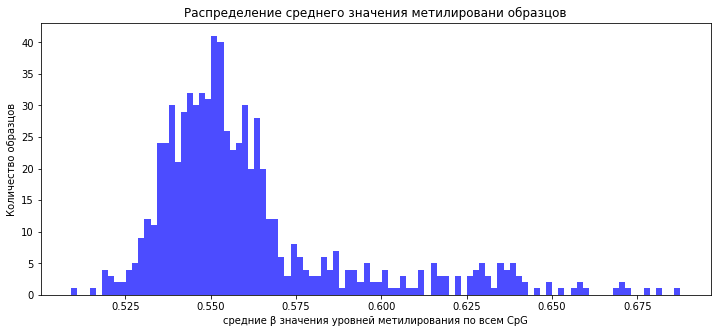

In [ ]:
fig, axes = plt.subplots(1,1, figsize = (12,5))
axes.hist(data_joined.loc[nan_thresh_sites, :].mean(axis=0),
          bins = 100,
          color = 'b',
          alpha = 0.7
         )
plt.title('Распределение среднего значения метилировани образцов')
axes.set_ylabel('Количество образцов')
axes.set_xlabel('средние β значения уровней метилирования по всем CpG')
plt.show()

## Загрузка описаний образцов

In [ ]:
samples_descriptions = pd.read_csv(path_main_dir + "/preprocessed/descriptions_samples.csv",
                          index_col=0)

In [ ]:
samples_descriptions

,Sample_geo_accession,sex,age,group
X1,GSM2333901,Male,72,70_74
X2,GSM2333902,Male,55,55_59
X3,GSM2333903,Male,23,20_24
X4,GSM2333904,Male,86,85_89
X5,GSM2333905,Male,74,70_74
...,...,...,...,...
X728,GSM2334631,Male,72,70_74
X729,GSM2334632,Male,54,50_54
X730,GSM2334633,Female,52,50_54
X731,GSM2334634,Female,45,45_49


## Загрузка дополнительных признаков образцов

In [ ]:
additional_desсriptions = pd.read_csv(
    path_main_dir+"/preprocessed/desсriptions_samples_additional.csv",
    index_col = 0
    )

In [ ]:
additional_desсriptions

,Unnamed: 1,year_of_collection,smoke,X9:136141870:C:T,exm792804,Adrenomedullin,CCL24,CCL19,CD30:L,CXCL10,CXCL11,CXCL13,CXCL5,Cystatin_B,E:selectin,Ep:CAM,Flt3L,Follistatin,GDF:15,Galectin:3,HB:EGF,WFDC2,IL:12,IL17RB,IL2RA,IL6RA,Kallikrein:11,MCP:1,MIA,MIC:A,MPO,Midkine,PECAM:1,PlGF,Stem_cell_factor,TIE2,TNF:RI,TNFRSF4,VEGF:A,VEGFR:2,SRC,TRAIL,IL27:A,CXCL1,FGF:23,IL:18,HSP_27,MMP:1,RETN,CHI3L1,ST2,TIM,mAmP,TM,MMP:10,CCL4,RAGE,MMP:7,CXCL6,Dkk:1,GAL,AGRP,CD40,t:PA,ESM:1,MMP:12,CX3CL1,NEMO,ECP,Sample_Group,CD8T,CD4T,NK,Bcell,Mono,Gran,KA,Slide,chip:ass
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
X1,GSM2333901,2006,0.0,1.0,1.0,-1.375617,0.187847,-0.442783,1.426913,-0.388297,-0.171808,-0.612210,0.744700,-1.467445,-1.534654,-1.163835,-0.841996,0.154370,-1.128328,-0.628150,-1.222798,-1.770762,0.052629,-0.849271,-1.722413,0.519578,-0.652132,-0.985784,-1.794659,-0.462956,0.455443,-1.461944,-1.118441,-0.577675,0.676968,-0.939792,-1.509525,-0.788905,-1.329659,0.049996,-0.266567,2.258197,-0.529795,0.703427,-1.360166,-0.343091,-0.347834,0.602676,-0.194233,-0.226714,1.309318,-0.872950,1.384375,-1.538897,-0.949529,-0.882084,-1.620621,-1.089906,-1.012845,-1.071201,2.069475,-1.017211,-1.211232,-0.424535,-1.443771,-2.292926,-0.768403,0.146591,-0.500014,2013,0.000000,0.100050,0.103269,0.015374,0.051578,0.728901,KA06,9370847096,7.0
X2,GSM2333902,2006,0.0,0.0,2.0,0.477876,-0.039464,0.787021,NaN,0.110696,-0.209308,0.504584,1.375617,0.204806,2.044305,0.084268,1.239636,-0.607515,2.003528,0.126589,0.463185,1.298476,-0.312764,0.094809,0.543815,-0.285259,1.520785,0.049996,1.115844,NaN,-0.662132,1.485314,-0.891786,0.730888,-2.023496,0.007891,0.624950,0.030813,0.707045,0.436989,-0.660637,0.075715,0.933278,1.726335,-0.497060,0.949529,-0.439222,-0.371871,-0.673671,0.120526,2.372046,2.682873,0.553459,1.787347,1.458724,0.949529,0.889808,2.330664,-0.368099,0.293695,1.749962,0.855454,-0.889808,-1.094643,-0.905417,1.273294,0.970202,-1.421929,-1.039339,2013,0.007585,0.219594,0.097459,0.036715,0.094437,0.553426,KA06,9376538120,7.0
X3,GSM2333903,2006,0.0,0.0,1.0,1.211762,0.641018,1.606884,NaN,-1.509525,-0.939792,-0.145172,0.868538,1.400972,0.596424,0.492670,1.984328,2.488210,1.065911,-0.089548,-0.247105,0.321062,0.670368,0.428470,-0.528630,-0.605878,-0.249780,-0.543815,-0.456472,NaN,-0.047462,-1.138326,1.984328,0.827092,0.486740,0.593285,0.927590,-0.405764,0.899642,-0.190524,0.593944,-1.681778,0.584635,-0.590836,-0.354179,-1.222168,0.566178,0.915693,-0.269271,-0.998495,0.470669,-1.283932,0.125982,-0.318296,-0.654162,0.786044,-0.307340,-0.882084,-1.366774,0.667140,-0.961883,-0.941372,1.787347,0.657396,0.427391,-0.010434,-0.740664,1.692605,0.088801,2012,0.000000,0.018278,0.005066,0.035204,0.092227,0.827294,KA06,7766148053,7.0
X4,GSM2333904,2006,0.0,0.0,1.0,0.360086,-0.631357,0.565287,NaN,0.214688,0.399667,1.094189,1.461944,0.543285,0.201249,0.513567,0.285259,-0.431381,0.935709,1.323319,-0.329381,0.147831,1.323319,0.348557,-1.211762,0.463185,0.786454,-0.797822,0.824061,1.185426,1.297288,0.233568,0.531657,0.657254,-0.602720,-0.388297,0.047362,-0.408807,0.153151,-0.834521,0.901494,-0.547891,0.761414,1.138426,-0.062641,-1.315489,1.348907,NaN,0.700090,-0.264429,-0.933278,-1.392694,-2.529537,-1.026002,-1.681778,0.013042,0.600179,-0.218213,-0.757933,-0.343091,-0.547891,-0.202213,0.713484,-0.065255,-0.740664,-0.631711,-1.118702,0.933278,-0.600179,2012,0.024722,0.179235,0.152868,0.020081,0.113306,0.496979,KA06,7766148077,7.0
X5,GSM2333905,2006,0.0,0.0,1.0,0.126589,0.301735,-0.360086,-0.790104,0.931642,1.493287,0.673664,-1.667133,-0.398583,-0.667079,-0.808717,0.644251,-0.260369,0.680280,-0.492670,-1.274409,-0.857089,0.845751,0.568366,0.198566,-0.416820,-1.004885,-0.206620,-0.169859,NaN,1.596353,0.285259,-0.596424,0.084268,1.108662,0.290742,0.827092,0.151819,-0.469049,-0.241685,1.189784,1.443771,0.178308,0.520812,-0.390523,1.309318,0.915033,-1.014343,0.793169,-0.567483,-0.638093,-1.237639,NaN,0.622187,1.099404,0.878241,0.091420,-0.075715,

In [ ]:
additional_desсriptions.columns

Index(['Unnamed: 1', ' year_of_collection', ' smoke', ' X9:136141870:C:T',
       ' exm792804', ' Adrenomedullin', ' CCL24', ' CCL19', ' CD30:L',
       ' CXCL10', ' CXCL11', ' CXCL13', ' CXCL5', ' Cystatin_B', ' E:selectin',
       ' Ep:CAM', ' Flt3L', ' Follistatin', ' GDF:15', ' Galectin:3',
       ' HB:EGF', ' WFDC2', ' IL:12', ' IL17RB', ' IL2RA', ' IL6RA',
       ' Kallikrein:11', ' MCP:1', ' MIA', ' MIC:A', ' MPO', ' Midkine',
       ' PECAM:1', ' PlGF', ' Stem_cell_factor', ' TIE2', ' TNF:RI',
       ' TNFRSF4', ' VEGF:A', ' VEGFR:2', ' SRC', ' TRAIL', ' IL27:A',
       ' CXCL1', ' FGF:23', ' IL:18', ' HSP_27', ' MMP:1', ' RETN', ' CHI3L1',
       ' ST2', ' TIM', ' mAmP', ' TM', ' MMP:10', ' CCL4', ' RAGE', ' MMP:7',
       ' CXCL6', ' Dkk:1', ' GAL', ' AGRP', ' CD40', ' t:PA', ' ESM:1',
       ' MMP:12', ' CX3CL1', ' NEMO', ' ECP', ' Sample_Group', ' CD8T',
       ' CD4T', ' NK', ' Bcell', ' Mono', ' Gran', ' KA', ' Slide',
       ' chip:ass'],
      dtype='object')

## Загрузка описаний сайтов метилирования

In [ ]:
sites_descriptions = pd.read_csv(path_main_dir+"/preprocessed/descriptions_sites.csv",
                                index_col = 0)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (15,36) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
sites_descriptions

,Name,AddressA_ID,AlleleA_ProbeSeq,AddressB_ID,AlleleB_ProbeSeq,Infinium_Design_Type,Next_Base,Color_Channel,Forward_Sequence,Genome_Build,CHR,MAPINFO,SourceSeq,Chromosome_36,Coordinate_36,Strand,Probe_SNPs,Probe_SNPs_10,Random_Loci,Methyl27_Loci,UCSC_RefGene_Name,UCSC_RefGene_Accession,UCSC_RefGene_Group,UCSC_CpG_Islands_Name,Relation_to_UCSC_CpG_Island,Phantom,DMR,Enhancer,HMM_Island,Regulatory_Feature_Name,Regulatory_Feature_Group,DHS,RANGE_START,RANGE_END,RANGE_GB,SPOT_ID,Most_Common_Gene
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
cg00000029,cg00000029,14782418,AACTATACTAACRAAAAAATATCCAAAAAACACTAACRTATAAAAA...,NaN,NaN,II,NaN,NaN,TTTTTTAGATAAGGATATCCAGGCGATGAGGAAGTTTTACTTCTGG...,37.0,16,53468112.0,GCTGTACTGACGAGAAAATGTCCAAAAGACACTGACGTGTGAAGGT...,16,52025613,F,NaN,NaN,NaN,NaN,RBL2,NM_005611,TSS1500,chr16:53468284-53469209,N_Shore,NaN,NaN,NaN,NaN,16:53467838-53469685,Promoter_Associated,True,53468112.0,53468235.0,NC_000016.9,NaN,RBL2
cg00000108,cg00000108,12709357,ATACAATAAAACAAACCTAAAATAATCCTAACTCCRCTATCATCCT...,NaN,NaN,II,NaN,NaN,TCCATTTTGAAGGAAAAAAATGAAGGCTCTGAAAGTGTAAATCGCT...,37.0,3,37459206.0,CGGCCAGGATGACAGCGGAGCCAGGATCACCCCAGGTCTGTCTCAT...,3,37434210,F,rs9857774,NaN,NaN,NaN,C3orf35;C3orf35,NM_178339;NM_178342,Body;3'UTR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37459206.0,37459329.0,NC_000003.11,NaN,C3orf35
cg00000109,cg00000109,59755374,CAATACTAACAAACACATATACCCCCCCACAAATCTTAACTTCTAA...,NaN,NaN,II,NaN,NaN,GCCTTAGTCCTGAATGAGCCATTTCTCTAAGAAGTCCTGGCTTCTT...,37.0,3,171916037.0,AATACTAACAGGCACATGTACCCCCCCACAGATCTTGGCTTCTAAA...,3,173398731,F,rs9864492,NaN,NaN,NaN,FNDC3B;FNDC3B,NM_001135095;NM_022763,Body;Body,NaN,NaN,low-CpG:173398671-173398760,NaN,NaN,NaN,NaN,NaN,NaN,171916037.0,171916160.0,NC_000003.11,NaN,FNDC3B
cg00000165,cg00000165,12637463,CAAAATCTATTAATACAATAACTTTTAATAAAACAACTAAAACACA...,NaN,NaN,II,NaN,NaN,CTAAGTGCAGTCAGGATCTGTTAGTACAGTGGCTTTTGATGGAACA...,37.0,1,91194674.0,AGGATCTGTTAGTACAGTGGCTTTTGATGGAACAGCTGAGGCACAC...,1,90967262,R,NaN,NaN,NaN,NaN,NaN,NaN,NaN,chr1:91190489-91192804,S_Shore,NaN,CDMR,True,1:90967262-90967361,NaN,NaN,NaN,91194674.0,91194797.0,NC_000001.10,NaN,NaN
cg00000236,cg00000236,12649348,TATAACRTCATATTAAAAAAAACRATCTAACCCACCAATTTATACA...,NaN,NaN,II,NaN,NaN,CTCAGCGACAGTGTAGCGTCATGTTAGAGGAGACGATCTGACCCAC...,37.0,8,42263294.0,GTAGCGTCATGTTAGAGGAGACGATCTGACCCACCAGTTTGTACAT...,8,42382451,R,NaN,NaN,NaN,NaN,VDAC3;VDAC3,NM_005662;NM_001135694,3'UTR;3'UTR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42263294.0,42263417.0,NC_000008.10,NaN,VDAC3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
rs9363764,rs9363764,36689314,TAACTCCCTACCACCTAAAACAAAACAATAATACACTAACTAATTT...,NaN,NaN,II,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs9363764,NaN
rs939290,rs939290,70759471,ATTTTATTTTCACTTTCCACAACCATAAACCCTTCCACCCAACATA...,NaN,NaN,II,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs939290,NaN
rs951295,rs951295,11711409,AACAAACAAAAATACTACTCACAACTCTACTCATTAAAAAAACTCC...,39778441.0,AACAAACAAAAATACTACTCACAACTCTACTCATTAAAAAAACTCC...,I,C,Grn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs951295,NaN


In [ ]:
sites_descriptions.columns

Index(['Name', 'AddressA_ID', 'AlleleA_ProbeSeq', 'AddressB_ID',
       'AlleleB_ProbeSeq', 'Infinium_Design_Type', 'Next_Base',
       'Color_Channel', 'Forward_Sequence', 'Genome_Build', 'CHR', 'MAPINFO',
       'SourceSeq', 'Chromosome_36', 'Coordinate_36', 'Strand', 'Probe_SNPs',
       'Probe_SNPs_10', 'Random_Loci', 'Methyl27_Loci', 'UCSC_RefGene_Name',
       'UCSC_RefGene_Accession', 'UCSC_RefGene_Group', 'UCSC_CpG_Islands_Name',
       'Relation_to_UCSC_CpG_Island', 'Phantom', 'DMR', 'Enhancer',
       'HMM_Island', 'Regulatory_Feature_Name', 'Regulatory_Feature_Group',
       'DHS', 'RANGE_START', 'RANGE_END', 'RANGE_GB', 'SPOT_ID',
       'Most_Common_Gene'],
      dtype='object')

## Фильтрация данных

В таблице с данными метилирования оставим только сайты у которых есть привязка к гену, не более 1% пропусков, и p-value меньше 0.01 для 99% образцов, а также отфильтруем образцы оставив только те, у которых заполнены поля возраста и пола в таблице описания образцов.

In [ ]:
# Сайты у которых нет привязки к гену
sites_genesless = sites_descriptions.index[sites_descriptions['Most_Common_Gene'].isna()] 
sites_genesless

Index(['cg00000165', 'cg00000363', 'cg00000948', 'cg00001249', 'cg00001261',
       'cg00001269', 'cg00001593', 'cg00001747', 'cg00001809', 'cg00001930',
       ...
       'rs7746156', 'rs798149', 'rs845016', 'rs877309', 'rs9292570',
       'rs9363764', 'rs939290', 'rs951295', 'rs966367', 'rs9839873'],
      dtype='object', name='ID', length=119977)

In [ ]:
# Сайты метелирования c пропусками
nan_thresh_sites = data_joined.index[data_joined.isna().any(axis = 1)]
nan_thresh_sites

Index(['cg00050873', 'cg00212031', 'cg00213748', 'cg00214611', 'cg00455876',
       'cg02004872', 'cg02011394', 'cg02050847', 'cg02233190', 'cg02839557',
       ...
       'cg27662284', 'ch.22.138449R', 'ch.22.147839R', 'ch.22.149158R',
       'ch.22.243204R', 'ch.22.363412F', 'ch.22.436090R', 'ch.22.528917R',
       'ch.22.772318F', 'ch.22.44116734F'],
      dtype='object', name='ID_REF', length=35309)

In [ ]:
# Cайты метилирования, для которых 
# p-value меньше 0.01 для не менее чем 99% образцов
p_value_thresh_sites = p_value_detection.index\
    [((p_value_detection >= 0.01).sum(axis = 1)\
      / p_value_detection.shape[1]) >= 0.01]

p_value_thresh_sites

Index(['cg00050873', 'cg00212031', 'cg00213748', 'cg00214611', 'cg00455876',
       'cg02011394', 'cg02050847', 'cg02233190', 'cg02839557', 'cg02842889',
       ...
       'cg12478092', 'cg13116946', 'cg14042597', 'cg15044932', 'cg16997375',
       'cg17387122', 'cg21442271', 'cg22666875', 'ch.22.363412F',
       'ch.22.436090R'],
      dtype='object', name='ID_REF', length=2634)

In [ ]:
sites_to_drop = sites_genesless\
                .union(nan_thresh_sites)\
                .union(p_value_thresh_sites)

sites_to_drop

Index(['cg00000165', 'cg00000363', 'cg00000948', 'cg00001249', 'cg00001261',
       'cg00001269', 'cg00001593', 'cg00001747', 'cg00001793', 'cg00001809',
       ...
       'rs7746156', 'rs798149', 'rs845016', 'rs877309', 'rs9292570',
       'rs9363764', 'rs939290', 'rs951295', 'rs966367', 'rs9839873'],
      dtype='object', length=145212)

In [ ]:
samples_descriptions[(samples_descriptions[['sex','age']].isna().all(axis = 1)== False)]

,Sample_geo_accession,sex,age,group
X1,GSM2333901,Male,72,70_74
X2,GSM2333902,Male,55,55_59
X3,GSM2333903,Male,23,20_24
X4,GSM2333904,Male,86,85_89
X5,GSM2333905,Male,74,70_74
...,...,...,...,...
X728,GSM2334631,Male,72,70_74
X729,GSM2334632,Male,54,50_54
X730,GSM2334633,Female,52,50_54
X731,GSM2334634,Female,45,45_49


In [ ]:
data_methylation = data_joined.query('index not in @sites_to_drop'
                                    ).loc[:, samples_descriptions.index]
display(data_methylation.shape)
display(data_methylation.head())
display(data_methylation.tail())

(340365, 729)

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,...,X692,X693,X694,X695,X696,X697,X698,X699,X700,X701,X702,X703,X704,X705,X706,X707,X708,X709,X710,X711,X712,X713,X714,X715,X717,X718,X719,X720,X721,X722,X723,X724,X725,X726,X727,X728,X729,X730,X731,X732
ID_REF,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
cg01707559,0.091756,0.057094,0.070700,0.122446,0.086404,0.226748,0.075118,0.049789,0.279977,0.362271,0.267581,0.333599,0.080270,0.137782,0.253648,0.103620,0.277257,0.121889,0.284468,0.064816,0.089376,0.283005,0.089832,0.277409,0.279954,0.082187,0.225091,0.232445,0.227535,0.234886,0.260963,0.153408,0.179256,0.234275,0.205333,0.304628,0.261165,0.285644,0.276893,0.140739,...,0.257464,0.238086,0.261085,0.248674,0.125374,0.254792,0.269540,0.258717,0.057962,0.065752,0.066867,0.108559,0.098935,0.319786,0.210027,0.334831,0.256913,0.265094,0.144139,0.255188,0.234496,0.198099,0.218039,0.097173,0.288934,0.071449,0.108316,0.144949,0.257754,0.063540,0.050549,0.075837,0.248150,0.078525,0.134440,0.085143,0.081432,0.228677,0.222310,0.122803
cg02494853,0.032790,0.029831,0.024936,0.046584,0.020204,0.097938,0.031592,0.041213,0.052293,0.049333,0.106044,0.063556,0.050682,0.074502,0.043912,0.035347,0.079674,0.053374,0.056462,0.063755,0.065388,0.082400,0.051507,0.043209,0.076840,0.026026,0.050453,0.069259,0.050476,0.061692,0.068020,0.041026,0.072715,0.034844,0.068106,0.070301,0.104636,0.018758,0.045492,0.113578,...,0.059364,0.049433,0.022342,0.061363,0.053679,0.073268,0.024895,0.025039,0.004821,0.018135,0.014377,0.047148,0.039524,0.034196,0.089995,0.069288,0.035313,0.050774,0.054072,0.047593,0.002723,0.019830,0.032989,0.050164,0.059906,0.034561,0.017475,0.023543,0.035648,0.028096,0.013448,0.037088,0.037324,0.026454,0.084670,0.022366,0.024528,0.037231,0.045762,0.191773
cg03706273,0.041566,0.062096,0.025517,0.061010,0.030409,0.255483,0.029638,0.076723,0.089194,0.065940,0.171929,0.059788,0.049569,0.112403,0.056804,0.050870,0.181135,0.063378,0.078910,0.071903,0.035864,0.139130,0.030109,0.039184,0.111081,0.033413,0.198129,0.147160,0.040685,0.129642,0.190666,0.051202,0.156635,0.029523,0.068146,0.090220,0.238705,0.052184,0.071286,0.101698,...,0.104289,0.178555,0.029398,0.037208,0.040424,0.242701,0.014463,0.059582,0.011127,0.009094,0.023951,0.032782,0.045083,0.058286,0.146150,0.144813,0.049994,0.139175,0.053637,0.209727,0.026756,0.123965,0.064484,0.061777,0.133386,0.014623,0.030347,0.025956,0.063216,0.019033,0.009035,0.037083,0.111043,0.021373,0.062509,0.042210,0.064298,0.096641,0.047448,0.073706
cg15295597,0.053220,0.029649,0.025265,0.040190,0.034945,0.139337,0.024848,0.033814,0.069463,0.029122,0.092218,0.044422,0.049611,0.062019,0.035025,0.043354,0.054175,0.046756,0.026454,0.108297,0.044748,0.086359,0.042502,0.050427,0.070292,0.038742,0.063500,0.064647,0.065321,0.037286,0.077502,0.043224,0.086819,0.044422,0.075996,0.062278,0.110874,0.039685,0.036017,0.120685,...,0.037661,0.053307,0.027468,0.149005,0.052847,0.084523,0.037118,0.032135,0.017046,0.018900,0.034516,0.048266,0.037358,0.033745,0.115625,0.076073,0.024511,0.041163,0.052643,0.069033,0.032724,0.034277,0.032678,0.039873,0.068895,0.038466,0.029714,0.038773,0.071045,0.021107,0.011668,0.060157,0.035454,0.016260,0.092267,0.035460,0.046284,0.049554,0.052715,0.167146
cg27539833,0.906486,0.923817,0.900892,0.922680,0.905139,0.900159,0.910428,0.895712,0.915642,0.918314,0.898990,0.890178,0.923173,0.900381,0.899618,0.932438,0.916348,0.912036,0.914516,0.904751,0.915163,0.922761,0.878383,0.936028,0.896873,0.931867,0.918785,0.918400,0.888448,0.908707,0.909101,0.927801,0.887674,0.888702,0.905653,0.886236,0.899471,0.915815,0.884783,0.888080,...,0.920145,0.907122,0.903160,0.882966,0.877362,0.894166,0.841397,0.925765,0.963638,0.938356,0.977059,0.917354,0.925539,0.913809,0.887790,0.893172,0.909897,0.900820,0.942012,0.912598,0.909215,0.903357,0.910113,0.914049,0.913749,0.900533,0.92823

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,...,X692,X693,X694,X695,X696,X697,X698,X699,X700,X701,X702,X703,X704,X705,X706,X707,X708,X709,X710,X711,X712,X713,X714,X715,X717,X718,X719,X720,X721,X722,X723,X724,X725,X726,X727,X728,X729,X730,X731,X732
ID_REF,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ch.22.728807R,0.106295,0.073127,0.115979,0.092891,0.150775,0.062394,0.120724,0.119934,0.160917,0.138326,0.101427,0.168561,0.091982,0.110990,0.112691,0.221408,0.055036,0.122721,0.115600,0.188163,0.116686,0.118480,0.147303,0.135337,0.153679,0.153705,0.137118,0.171405,0.164892,0.139649,0.150313,0.115623,0.136104,0.141911,0.120814,0.110130,0.154220,0.142009,0.145719,0.118158,...,0.130687,0.110416,0.129318,0.111889,0.152034,0.138603,0.116949,0.082364,0.079791,0.106145,0.198774,0.127730,0.112160,0.107065,0.109601,0.115675,0.106309,0.105729,0.082789,0.114165,0.087485,0.096167,0.084303,0.137375,0.134084,0.111731,0.094634,0.133973,0.121023,0.092975,0.053606,0.098119,0.156609,0.082644,0.127034,0.081969,0.123049,0.147310,0.077081,0.100998
ch.22.734399R,0.087009,0.194002,0.130208,0.120509,0.136613,0.113992,0.145297,0.184315,0.187541,0.151660,0.114078,0.133598,0.128906,0.131432,0.131016,0.180977,0.160505,0.146773,0.126431,0.157818,0.109159,0.103304,0.103658,0.123905,0.165875,0.193880,0.152216,0.211980,0.161659,0.118361,0.126127,0.079115,0.159608,0.103821,0.215958,0.143129,0.097673,0.129355,0.122065,0.077341,...,0.188204,0.128191,0.192874,0.099823,0.129820,0.121613,0.140634,0.104729,0.180653,0.112927,0.175053,0.096361,0.120509,0.130014,0.111851,0.092326,0.128464,0.156459,0.133139,0.128430,0.213176,0.128253,0.118457,0.133404,0.146450,0.164047,0.157437,0.177332,0.104779,0.108225,0.061082,0.195230,0.092118,0.134737,0.147923,0.146447,0.134767,0.123749,0.205997,0.126280
ch.22.740407F,0.021154,0.027324,0.023570,0.025149,0.027056,0.013594,0.012174,0.024958,0.029098,0.039945,0.027027,0.020318,0.023739,0.019655,0.020569,0.029362,0.021017,0.026555,0.029541,0.043920,0.024007,0.021088,0.024349,0.025788,0.034275,0.021688,0.046965,0.034018,0.035654,0.019162,0.016656,0.030520,0.026046,0.026433,0.028817,0.036912,0.023584,0.017231,0.028918,0.025349,...,0.012645,0.034702,0.019357,0.036610,0.041249,0.035018,0.035354,0.017935,0.006548,0.017542,0.023639,0.019933,0.019680,0.028460,0.026616,0.023222,0.028357,0.028751,0.023301,0.025382,0.017234,0.037075,0.024799,0.016408,0.022238,0.006804,0.017943,0.033538,0.020213,0.016043,0.020774,0.027415,0.013585,0.025202,0.023264,0.027409,0.026960,0.031105,0.012739,0.021916
ch.22.757911F,0.039410,0.046239,0.020225,0.019679,0.029783,0.050819,0.034501,0.059055,0.066130,0.052018,0.039889,0.033203,0.028248,0.033200,0.022893,0.048833,0.033808,0.036494,0.031899,0.037185,0.030862,0.023868,0.051372,0.023939,0.045551,0.043357,0.041058,0.038809,0.047387,0.038285,0.034225,0.039863,0.051892,0.037130,0.036797,0.038206,0.040599,0.035841,0.021835,0.023686,...,0.082873,0.038677,0.074113,0.030441,0.047393,0.040282,0.040188,0.018116,0.017566,0.047521,0.049953,0.030524,0.042267,0.042137,0.011994,0.020596,0.025394,0.027225,0.039415,0.019954,0.026840,0.050881,0.031783,0.030945,0.029692,0.033601,0.068538,0.012023,0.034701,0.021377,0.026359,0.031102,0.035200,0.022480,0.049777,0.048689,0.038484,0.021322,0.056414,0.022184
ch.22.909671F,0.057891,0.031434,0.048693,0.033916,0.103210,0.144609,0.087954,0.106434,0.148038,0.221108,0.036939,0.097592,0.082205,0.115931,0.052637,0.100538,0.042937,0.080679,0.062808,0.092836,0.110316,0.064870,0.152929,0.085572,0.080871,0.084137,0.122997,0.172195,0.113289,0.044373,0.038711,0.103955,0.114025,0.135720,0.102636,0.071352,0.149546,0.050092,0.104446,0.049064,...,0.267697,0.134900,0.114580,0.053549,0.171110,0.084451,0.083516,0.049093,0.079479,0.114183,0.286561,0.080388,0.074615,0.063037,0.066450,0.070672,0.113976,0.081349,0.155391,0.060092,0.147663,0.103639,0.123045,0.131115,0.131512,0

In [ ]:
# Сохраним отфильтрованные данные
data_methylation.to_csv(path_main_dir+'/preprocessed/data_methylation_clear.csv')

In [ ]:
del data_joined

In [ ]:
data_methylation = pd.read_csv(
                        path_main_dir+'/preprocessed/data_methylation_clear.csv',
                        index_col = 0
                        )

In [ ]:
display(data_methylation.shape)
display(data_methylation.head())
display(data_methylation.tail())

(340365, 729)

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X723,X724,X725,X726,X727,X728,X729,X730,X731,X732
ID_REF,,,,,,,,,,,,,,,,,,,,,
cg01707559,0.091756,0.057094,0.070700,0.122446,0.086404,0.226748,0.075118,0.049789,0.279977,0.362271,...,0.050549,0.075837,0.248150,0.078525,0.134440,0.085143,0.081432,0.228677,0.222310,0.122803
cg02494853,0.032790,0.029831,0.024936,0.046584,0.020204,0.097938,0.031592,0.041213,0.052293,0.049333,...,0.013448,0.037088,0.037324,0.026454,0.084670,0.022366,0.024528,0.037231,0.045762,0.191773
cg03706273,0.041566,0.062096,0.025517,0.061010,0.030409,0.255483,0.029638,0.076723,0.089194,0.065940,...,0.009035,0.037083,0.111043,0.021373,0.062509,0.042210,0.064298,0.096641,0.047448,0.073706
cg15295597,0.053220,0.029649,0.025265,0.040190,0.034945,0.139337,0.024848,0.033814,0.069463,0.029122,...,0.011668,0.060157,0.035454,0.016260,0.092267,0.035460,0.046284,0.049554,0.052715,0.167146
cg27539833,0.906486,0.923817,0.900892,0.922680,0.905139,0.900159,0.910428,0.895712,0.915642,0.918314,...,0.967174,0.926606,0.862893,0.925957,0.937382,0.934757,0.924624,0.892350,0.918526,0.904782


,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X723,X724,X725,X726,X727,X728,X729,X730,X731,X732
ID_REF,,,,,,,,,,,,,,,,,,,,,
ch.22.728807R,0.106295,0.073127,0.115979,0.092891,0.150775,0.062394,0.120724,0.119934,0.160917,0.138326,...,0.053606,0.098119,0.156609,0.082644,0.127034,0.081969,0.123049,0.147310,0.077081,0.100998
ch.22.734399R,0.087009,0.194002,0.130208,0.120509,0.136613,0.113992,0.145297,0.184315,0.187541,0.151660,...,0.061082,0.195230,0.092118,0.134737,0.147923,0.146447,0.134767,0.123749,0.205997,0.126280
ch.22.740407F,0.021154,0.027324,0.023570,0.025149,0.027056,0.013594,0.012174,0.024958,0.029098,0.039945,...,0.020774,0.027415,0.013585,0.025202,0.023264,0.027409,0.026960,0.031105,0.012739,0.021916
ch.22.757911F,0.039410,0.046239,0.020225,0.019679,0.029783,0.050819,0.034501,0.059055,0.066130,0.052018,...,0.026359,0.031102,0.035200,0.022480,0.049777,0.048689,0.038484,0.021322,0.056414,0.022184
ch.22.909671F,0.057891,0.031434,0.048693,0.033916,0.103210,0.144609,0.087954,0.106434,0.148038,0.221108,...,0.158166,0.064856,0.141411,0.102136,0.091702,0.174574,0.122583,0.083451,0.116304,0.057085


In [ ]:
samples_descriptions.index

,Sample_geo_accession,sex,age,group
X1,GSM2333901,Male,72,70_74
X2,GSM2333902,Male,55,55_59
X3,GSM2333903,Male,23,20_24
X4,GSM2333904,Male,86,85_89
X5,GSM2333905,Male,74,70_74
...,...,...,...,...
X728,GSM2334631,Male,72,70_74
X729,GSM2334632,Male,54,50_54
X730,GSM2334633,Female,52,50_54
X731,GSM2334634,Female,45,45_49


## Подготовка данных для моделирования

In [ ]:
male_columns = samples_descriptions.query('sex == "Male"').index
female_columns = samples_descriptions.query('sex == "Female"').index

In [ ]:
data_methylation_for_ml_male = data_methylation[male_columns]
data_methylation_for_ml_female = data_methylation[female_columns]
print(data_methylation_for_ml_male.shape)
print(data_methylation_for_ml_female.shape)

(340365, 341)
(340365, 388)


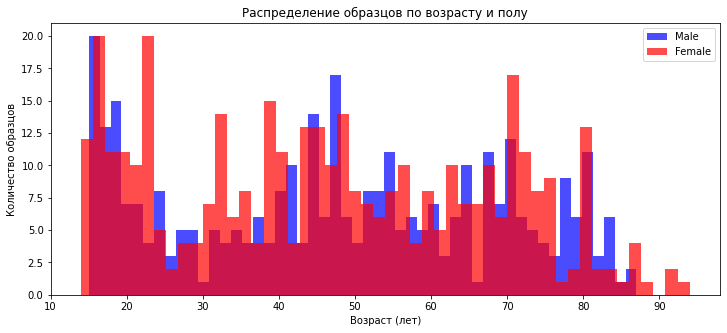

In [ ]:
fig, axes = plt.subplots(1,1, figsize = (12,5))

axes.hist(samples_descriptions[samples_descriptions['sex'] == 'Male']['age'].sort_values(),
         bins = 50,
         alpha=0.7,
         label = 'Male',
          color = 'b',
        )
axes.hist(samples_descriptions[samples_descriptions['sex'] == 'Female']['age'].sort_values(),
         bins = 50,
         alpha=0.7,
         label = 'Female',
          color = 'r',
        )
plt.title('Распределение образцов по возрасту и полу')
axes.set_ylabel('Количество образцов')
axes.set_xlabel('Возраст (лет)')
plt.legend()
plt.show()

## Загрузка разбивки сайтов по группам

In [ ]:
hallmarks_genes = pd.read_csv(
                            path_root_dir\
                            +r'/hallmarks_genes'/
                            +r'/hallmark_genes.csv',
                            index_col = 0
                             )

In [ ]:
hallmarks_genes

,group,genes
2,TNFA_SIGNALING_VIA_NFKB,JUNB
3,TNFA_SIGNALING_VIA_NFKB,CXCL2
4,TNFA_SIGNALING_VIA_NFKB,ATF3
5,TNFA_SIGNALING_VIA_NFKB,NFKBIA
6,TNFA_SIGNALING_VIA_NFKB,TNFAIP3
...,...,...
37,PANCREAS_BETA_CELLS,PAK3
38,PANCREAS_BETA_CELLS,G6PC2
39,PANCREAS_BETA_CELLS,PKLR
40,PANCREAS_BETA_CELLS,LMO2


## Предсказание возраста по профилю метилирования

### Построение моделей на данных всех сайтов

Проведем отбор сайтов с помощью регуляризации линейных моделей ElasticNet -- объединяющей два подхода добавления к функции потерь модуля вектора весов (l1 регуляризация) и квадрата нормы(l2 регуляризация) в пропорциях заданных коэффициентом l1_ratio

In [ ]:
# Напишем функцию подсчета абсолютной средней ошибки
def mae(true: np.array, predict: np.array) -> float:
    result = sum(np.abs(true - predict)) / true.shape[0]
    return result

In [ ]:
samples_descriptions

,Sample_geo_accession,sex,age,group
X1,GSM2333901,Male,72,70_74
X2,GSM2333902,Male,55,55_59
X3,GSM2333903,Male,23,20_24
X4,GSM2333904,Male,86,85_89
X5,GSM2333905,Male,74,70_74
...,...,...,...,...
X728,GSM2334631,Male,72,70_74
X729,GSM2334632,Male,54,50_54
X730,GSM2334633,Female,52,50_54
X731,GSM2334634,Female,45,45_49


In [ ]:
samples_train = samples_descriptions.sample(frac = 0.8, random_state = 12345)[['sex','age']]
samples_test = samples_descriptions.query('index not in @samples_train.index')[['sex','age']]

In [ ]:
samples_train.age.hist(bins = 20,density = True, alpha = 0.7, color = 'r', label = 'Train')
samples_test.age.hist(bins = 20,density = True, alpha = 0.7, color = 'b', label = 'Test')   
plt.legend()
plt.show()

In [ ]:
male_samples_train = samples_train.query('sex == "Male"')
female_samples_train = samples_train.query('sex == "Female"')

In [ ]:
male_samples_test = samples_test.query('sex == "Male"')
female_samples_test = samples_test.query('sex == "Female"')

In [ ]:
# Множества сайтов метилирования для тестовых и тренировочных образцов
male_train_x = data_methylation[male_samples_train.index].T
male_test_x = data_methylation[male_samples_test.index].T

female_train_x = data_methylation[female_samples_train.index].T
female_test_x = data_methylation[female_samples_test.index].T

male_train_y = male_samples_train['age'].values
female_train_y = female_samples_train['age'].values

male_test_y = male_samples_test['age'].values
female_test_y = female_samples_test['age'].values

In [ ]:
train_test_data = {'male_train_x' : male_train_x,
                   'male_test_x' : male_test_x,
                   'female_train_x' : female_train_x,
                   'female_test_x' : female_test_x,
                   'male_train_y' : male_train_y,
                   'female_train_y' : female_train_y,
                   'male_test_y' : male_test_y,
                   'female_test_y' : female_test_y}

for x in list(train_test_data.keys()):
    print(x, train_test_data[x].shape)

male_train_x (275, 340365)
male_test_x (66, 340365)
female_train_x (308, 340365)
female_test_x (80, 340365)
male_train_y (275,)
female_train_y (308,)
male_test_y (66,)
female_test_y (80,)


In [ ]:
start = time.time()
elastic_net_male = ElasticNet(alpha = 0.05,
                              l1_ratio=0.54,
                              max_iter = 2000,
                              random_state = 12345                               
                              )


elastic_net_female = ElasticNet(alpha = 0.01,
                                l1_ratio=0.45,
                                max_iter= 3000,
                                random_state = 12345                               
                                )

elastic_net_male.fit(male_train_x, male_train_y)
print('|', end = '')

elastic_net_female.fit(female_train_x, female_train_y)
print('|')

print('Время обучения составило', str(int(time.time() - start)), 'сек')

||
Время обучения составило 240 сек


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.278e+01, tolerance: 1.288e+01


In [ ]:
mae_elastic_net_male = mae(male_test_y, elastic_net_male.predict(male_test_x))
mae_elastic_net_female = mae(female_test_y, elastic_net_female.predict(female_test_x))

print('mae_elastic_net_male', mae_elastic_net_male)
print('mae_elastic_net_female', mae_elastic_net_female)

mae_elastic_net_male 3.6363149455499495
mae_elastic_net_female 4.133725928203097


In [ ]:
# сохраним веса моделей в таблицу
elastic_net_weights = pd.DataFrame(elastic_net_male.coef_[elastic_net_male.coef_ != 0],
    index = male_train_x.columns[elastic_net_male.coef_ != 0],
            columns = ['weight_male'])\
.join(pd.DataFrame(elastic_net_female.coef_[elastic_net_female.coef_ != 0],
    index = female_train_x.columns[elastic_net_female.coef_ != 0],
            columns = ['weight_female']), how = 'outer')

elastic_net_weights = elastic_net_weights.dropna()

elastic_net_weights

,weight_male,weight_female
ID_REF,,
cg00029246,-0.350723,-0.212600
cg00059225,0.008058,0.403582
cg00094518,0.465700,0.425407
cg00144180,0.549912,0.703477
cg00176863,0.274506,0.456309
...,...,...
cg27367526,-0.344875,-0.383290
cg27436995,2.156537,1.853273
cg27549720,0.188694,0.234936


In [ ]:
# Объединим полученную таблицу с описаниями сайтов
elastic_net_sites = elastic_net_weights[['weight_male', 'weight_female']].join(sites_descriptions, how = 'left')

In [ ]:
elastic_net_sites.to_csv(path_main_dir+'/models/elastic_net_sites_cuted.csv')

In [ ]:
elastic_net_weights.to_csv(path_main_dir+'/models/elastic_net_weights_cuted.csv')

## Анализ весов модели

In [ ]:
elastic_net_weights = pd.read_csv(path_main_dir+'/models/elastic_net_weights_cuted.csv',
                                  index_col=0
                                 )

In [ ]:
elastic_net_sites = pd.read_csv(path_main_dir+'/models/elastic_net_sites_cuted.csv',
                                  index_col=0
                                 )

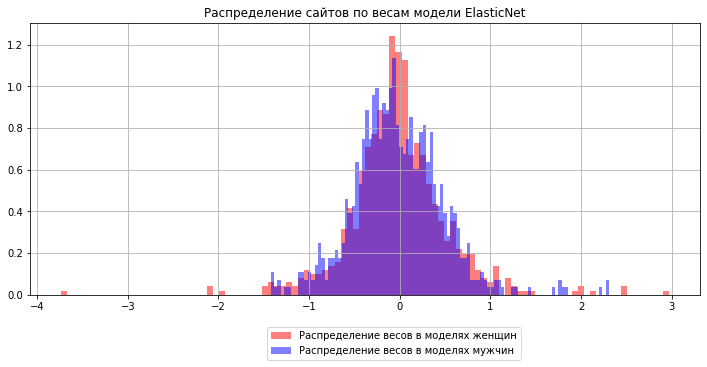

In [ ]:
# Выведем график распределения признаков по весам
plt.figure(figsize = (12,5))

elastic_net_weights[
    'weight_male']\
            .hist(bins=100,
                  density = True,
                  color = 'r',
                  alpha = 0.5,
                  label = 'Распределение весов в моделях женщин'
                 )

elastic_net_weights[
    'weight_female']\
            .hist(bins=100,
                  density = True,
                  color = 'b',
                  alpha = 0.5,
                  label = 'Распределение весов в моделях мужчин'
                 )

plt.legend(
#   loc='lower left',
    bbox_to_anchor=(0.74, -0.1)
)
plt.title('Распределение сайтов по весам модели ElasticNet')
plt.show()

In [ ]:
# Создадим таблицу с группировкой сайтов по группам
elastic_net_hallmarks = elastic_net_sites[[
                                           'weight_male',
                                           'weight_female',
                                           'Name',
                                           'Most_Common_Gene'
                                          ]]

In [ ]:
elastic_net_hallmarks = elastic_net_hallmarks\
                    .set_index('Most_Common_Gene', drop = True)\
                    .join(hallmarks_genes.set_index('genes', drop = True)\
                    , how = 'left')

In [ ]:
elastic_net_hallmarks = elastic_net_hallmarks.reset_index()
elastic_net_hallmarks.columns = ['gene','weight_male','weight_female','cpg_name','group']
elastic_net_hallmarks

,gene,weight_male,weight_female,cpg_name,group
0,A2BP1,-0.141245,-0.203486,cg03623568,NaN
1,AAK1,0.370512,-0.168234,cg17149911,NaN
2,ABCC4,-0.354410,-0.254976,cg05412028,ANDROGEN_RESPONSE
3,ABCC4,-0.571178,-0.524258,cg26685941,ANDROGEN_RESPONSE
4,ABCC5,-0.052006,-0.622407,cg01324343,P53_PATHWAY
...,...,...,...,...,...
859,ZP2,-0.439447,-0.057365,cg06819923,NaN
860,ZYG11A,0.347869,0.528300,cg06335143,NaN
861,ZYG11A,0.342286,0.268851,cg06784991,NaN
862,ZYG11A,0.463173,0.653177,cg24466241,NaN


In [ ]:
# Для удобства сравнения разобъем все сайты по вкладу 
# в формулу возраста на негативные и позитивные
positive_male = elastic_net_hallmarks[elastic_net_hallmarks['weight_male'] > 0].drop('weight_female', axis = 1)
negative_male = elastic_net_hallmarks[elastic_net_hallmarks['weight_male'] < 0].drop('weight_female', axis = 1)

positive_female = elastic_net_hallmarks[elastic_net_hallmarks['weight_female'] > 0].drop('weight_male', axis = 1)
negative_female = elastic_net_hallmarks[elastic_net_hallmarks['weight_female'] < 0].drop('weight_male', axis = 1)

In [ ]:
# Соберем данные в словарь
hallmarks_elastic_net = {
    'positive_male':positive_male,
    'negative_male':negative_male,
    'positive_female':positive_female,
    'negative_female':negative_female
}

In [ ]:
for key, data in hallmarks_elastic_net.items():
    hallmarks_elastic_net[key] = data.join(data.groupby(by='group').sum(),
                     rsuffix='_group',
                     on = 'group',
                     how = 'outer')

In [ ]:
hallmarks_elastic_net['positive_male']

,gene,weight_male,cpg_name,group,weight_male_group
1,AAK1,0.370512,cg17149911,NaN,NaN
21,ACSF3,0.602336,cg03172657,NaN,NaN
26,ACTL6B,0.098378,cg24471254,NaN,NaN
28,ADAMTSL5,0.152500,cg22994198,NaN,NaN
29,ADCY5,0.573249,cg04908625,NaN,NaN
...,...,...,...,...,...
701,SCG3,0.203600,cg01908954,SPERMATOGENESIS,0.203600
750,SST,0.489826,cg00481951,PANCREAS_BETA_CELLS,1.099156
751,SST,0.609330,cg25478614,PANCREAS_BETA_CELLS,1.099156
755,STK25,0.499487,cg09289202,REACTIVE_OXYGEN_SPECIES_PATHWAY,0.499487


In [ ]:
for key, data in hallmarks_elastic_net.items():
    print(key, data.shape, sum(abs(data.iloc[:, 1])))

positive_male (379, 5) 157.73781078312314
negative_male (485, 5) 176.42064291737287
positive_female (381, 5) 154.31943303990627
negative_female (483, 5) 180.18448167783959


## Селекция признаков

In [ ]:
#Оставим сайты имеющие наибольший модуль веса в подгруппах у мужчин и женщин
elastic_net_hallamrks_sites = elastic_net_hallmarks.copy()

elastic_net_hallamrks_sites['weight_male_abs'] = abs(elastic_net_hallmarks['weight_male'])
elastic_net_hallamrks_sites['weight_female_abs'] = abs(elastic_net_hallmarks['weight_female'])

top_male = elastic_net_hallamrks_sites.sort_values(by = 'weight_male_abs', ascending = False)['cpg_name'].values[:95]
top_female = elastic_net_hallamrks_sites.sort_values(by = 'weight_female_abs', ascending = False)['cpg_name'].values[:90]

top_weighted_male = set(top_male).union(top_female)

top_male = elastic_net_hallamrks_sites.sort_values(by = 'weight_male_abs', ascending = False)['cpg_name'].values[:20]
top_female = elastic_net_hallamrks_sites.sort_values(by = 'weight_female_abs', ascending = False)['cpg_name'].values[:90]

top_weighted_female = set(top_male).union(top_female)

# Выведем количество оставшихся сайтов
display(len(top_weighted_male))
display(len(top_weighted_female))

106

72

In [ ]:
male_scaler = StandardScaler()
female_scaler = StandardScaler()

In [ ]:
male_train_x_scaled = pd.DataFrame(male_scaler.fit_transform(male_train_x),
                      index = male_train_x.index,
                      columns = male_train_x.columns)
male_test_x_scaled = pd.DataFrame(male_scaler.transform(male_test_x),
                     index = male_test_x.index,
                     columns = male_test_x.columns)

female_train_x_scaled = pd.DataFrame(female_scaler.fit_transform(female_train_x),
                        index = female_train_x.index,
                        columns = female_train_x.columns)
female_test_x_scaled = pd.DataFrame(female_scaler.transform(female_test_x),
                       index = female_test_x.index,
                       columns = female_test_x.columns)

display(male_train_x_scaled.mean(axis = 1).mean())
display(male_test_x_scaled.mean(axis = 1).mean())

display(female_train_x_scaled.mean(axis = 1).mean())
display(female_test_x_scaled.mean(axis = 1).mean())

-1.1505947709751622e-17

-0.026009978714196677

5.479022718929344e-17

-0.00043182696641060335

In [ ]:
elastic_net_male = ElasticNet(alpha = 0.003,
                           l1_ratio=0.54,
                               max_iter = 3000,
                            
                               random_state = 12345                               
                              )

elastic_net_female = ElasticNet(alpha = 0.003,
                             l1_ratio=0.45,
                                max_iter= 3000,
                            
                               random_state = 12345                               
                              )

elastic_net_male.fit(male_train_x[list(top_weighted_male)], male_train_y)
elastic_net_female.fit(female_train_x[list(top_weighted_female)], female_train_y)

mae_elastic_net_male = mae(male_test_y, elastic_net_male.predict(male_test_x[list(top_weighted_male)]))
mae_elastic_net_female = mae(female_test_y, elastic_net_female.predict(female_test_x[list(top_weighted_female)]))

print('mae_elastic_net_male', mae_elastic_net_male)
print('mae_elastic_net_female', mae_elastic_net_female)
print('Total Mean', np.mean([mae_elastic_net_male, mae_elastic_net_female]))

mae_elastic_net_male 2.9271625745155707
mae_elastic_net_female 2.9663368681855413
Total Mean 2.946749721350556


## Сохранение полученных моделей

In [ ]:
joblib.dump(elastic_net_male, path_main_dir + '/models/final_elastic_net_male.sav')
joblib.dump(elastic_net_female, path_main_dir + '/models/final_elastic_net_female.sav')

['C:\\Users\\IvanovNikita\\OneDrive - ООО «АЛЬМА Сервисез Компани»\\Рабочий стол\\bioinformatics\\geo_methylation_datasets\\GSE87571\\models\\final_elastic_net_female.sav']

In [ ]:
elastic_net_male = joblib.load(path_main_dir + '/models/final_elastic_net_male.sav')
elastic_net_female = joblib.load(path_main_dir + '/models/final_elastic_net_female.sav')

In [ ]:
pd.DataFrame(top_weighted_male,
            columns = ['sites_male'],
            ).to_csv(path_main_dir + '/models/final_elastic_net_male_sites.csv')
pd.DataFrame(top_weighted_female,
            columns = ['sites_female'],
            ).to_csv(path_main_dir + '/models/final_elastic_net_female_sites.csv')

In [ ]:
final_elastic_net_sites = pd.DataFrame(
    index = male_train_x[list(top_weighted_male)].columns,
    data = elastic_net_male.coef_,
    columns = ['weight_male'])\
    .join(pd.DataFrame(
    index = female_train_x[list(top_weighted_female)].columns,
    data = elastic_net_female.coef_,
    columns = ['weight_female']),
    how ='outer')

In [ ]:
final_elastic_net_hallmarks = final_elastic_net_sites\
    .join(sites_descriptions[['Most_Common_Gene']], how = 'left')\
    .reset_index()\
    .set_index('Most_Common_Gene')\
    .join(hallmarks_genes.set_index('genes'), how = 'left')\
    .reset_index()

final_elastic_net_hallmarks.columns = ['gene', 'cpg_name', 'weight_male', 'weight_female', 'group']

In [ ]:
final_elastic_net_hallmarks = final_elastic_net_hallmarks.drop_duplicates(keep = 'first',
                                            subset = ['cpg_name'])

In [ ]:
final_elastic_net_hallmarks.to_csv(path_main_dir+'/models/final_hallmarks.csv')

In [ ]:
final_elastic_net_hallmarks = pd.read_csv(
                                path_main_dir+'/models/final_hallmarks.csv',
                                index_col = 0
                                           )
final_elastic_net_hallmarks

,gene,weight_male,weight_female,group
cpg_name,,,,
cg16867657,ELOVL2,10.650105,17.377274,ESTROGEN_RESPONSE_EARLY
cg07544187,CILP2,7.521758,14.473471,NaN
cg24724428,ELOVL2,7.053800,12.754742,ESTROGEN_RESPONSE_EARLY
cg14361627,KLF14,10.720293,10.849178,NaN
cg25410668,RPA2,6.987764,10.189043,DNA_REPAIR
...,...,...,...,...
cg07127410,ZNRF3,-4.799280,NaN,NaN
cg03873281,PDLIM4,-5.088620,NaN,EPITHELIAL_MESENCHYMAL_TRANSITION
cg01243823,NOD2,-6.311090,NaN,INFLAMMATORY_RESPONSE


In [ ]:
final_elastic_net_hallmarks.group.isna().sum()

82

## Визуализация финальной модели

In [ ]:
# Для удобства сравнения разобъем все сайты по вкладу 
# в формулу возраста на негативные и позитивные
positive_male = final_elastic_net_hallmarks\
                [final_elastic_net_hallmarks\
                 ['weight_male'] > 0].drop('weight_female', axis = 1)
negative_male = final_elastic_net_hallmarks\
                [final_elastic_net_hallmarks\
                 ['weight_male'] < 0].drop('weight_female', axis = 1)

positive_female = final_elastic_net_hallmarks\
                [final_elastic_net_hallmarks\
                 ['weight_female'] > 0].drop('weight_male', axis = 1)
negative_female = final_elastic_net_hallmarks\
                [final_elastic_net_hallmarks\
                 ['weight_female'] < 0].drop('weight_male', axis = 1)

In [ ]:
# Соберем данные в словарь
final_hallmarks = {
    'positive_male':positive_male,
    'negative_male':negative_male,
    'positive_female':positive_female,
    'negative_female':negative_female
    }

In [ ]:
for key, data in final_hallmarks.items():
    final_hallmarks[key] = data.join(data.groupby(by='group').sum(),
                     rsuffix='_group',
                     on = 'group',
                     how = 'outer')

In [ ]:
for key, data in final_hallmarks.items():
    print(key, data.shape, sum(abs(data.iloc[:, 1])))

positive_male (38, 4) 169.524752207699
negative_male (58, 4) 161.20380443943375
positive_female (34, 4) 177.9503252977195
negative_female (36, 4) 138.293776824539


In [ ]:
fig = make_subplots(1,1)

colors = {
           'positive_male' : 'rgba(255, 8, 24, 0.5)',
           'positive_female' : 'rgba(255, 8, 226, 0.5)',
           'negative_male': 'rgba(8, 177, 255, 0.5)',
           'negative_female' : 'rgba(8, 255, 169, 0.5)'
        }
for group, data in final_hallmarks.items():
    
    data_groupped = data.dropna(subset = ['group'])
    data_not_groupped = data.loc[data['group'].isna() == True]

    fig.add_trace(go.Scatter(
        x = data_groupped.iloc[:, 1],
        y = data_groupped['group'].str.lower(),
        text = data_groupped['gene'],
        mode = 'markers',
        marker = dict(
                 size = abs(data_groupped.iloc[:, 1])*8,
                 color = colors[group]
                 ),
        name = group
        ))
    
    fig.add_trace(go.Scatter(
        x = data_not_groupped.iloc[:, 1],
        y = data_not_groupped['gene'].str.lower(),
        text = data_not_groupped['gene'],
        mode = 'markers',
        marker = dict(
                 size = abs(data_not_groupped.iloc[:, 1])*8,
                 color = colors[group]
                 ),
        name = group + ' гены без привязки к группам'
        ))
    
fig.update_layout(
    
    height = 1000,
    width = 1500,
    legend = dict(itemsizing = 'constant'),
    paper_bgcolor='rgb(243, 243, 243)',
    plot_bgcolor='rgb(243, 243, 243)',
    xaxis = dict(),
    title = dict( 
        text = 'Распределение коэффициентов '/
                +'CpG сайтов (n = 106) в модели '/
                +'часов метилирования ElasticNet'/
                ' в разрезе групп генов',
        xanchor = 'center',
        yanchor = 'top',
        x = 0.5,
        y = 0.97
    ))

fig.update_xaxes(
        side = 'top',
        title_text = "Коэффициент веса в модели",
        title_standoff = 5)

fig.update_yaxes(
        title_text = "Функциональная группа генов/ген связаный с CpG)",
        title_standoff = 25)

fig.write_html(path_main_dir+'/visualizations/final_elastic_net_weights_by_groups.html')

<img src = "https://raw.githubusercontent.com/ComputationalAgingLab/MethylationClock/main/final_elastic_net_weights_by_groups.png"/>

## Сравнение финальной модели с часами метилирования by Horvath

Модель полученная первопроходцем в исследовании эпигенетических корреляций с процессами старения:
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4015143/

In [ ]:
horvath_clock_sites = pd.read_csv(
    path_root_dir+'/geo_methylation_datasets/Нorvath_clock.csv',
    header=2,
    index_col=0
)

In [ ]:
# Выведем пересечение CpG сайтов в обученой финальной модели и в модели часов метилирования Хоравата
horvath_clock_sites.loc[horvath_clock_sites.index[1:].intersection(final_elastic_net_hallmarks.index), :]

,CoefficientTraining,CoefficientTrainingShrunk,varByCpG,minByCpG,maxByCpG,medianByCpG,medianByCpGYoung,medianByCpGOld,Gene_ID,GenomeBuild,...,SourceVersion,TSS_Coordinate,Gene_Strand,Symbol,Synonym,Accession,GID,Annotation,Product,Marginal Age Relationship
cg09809672,-0.391319,-0.189295,0.042,0.0022,0.97,0.56,0.65,0.45,128178.0,36.0,...,36.1,234624303.0,+,EDARADD,NaN,NM_080738.2,GI:22325373,##############################################...,EDAR-associated death domain isoform B,negative
cg15804973,-0.108169,NaN,0.017,0.0000,0.84,0.26,0.34,0.22,4217.0,36.0,...,36.1,137155349.0,-,MAP3K5,ASK1; MEKK5; MAPKKK5;,NM_005923.3,GI:21536459,##############################################...,mitogen-activated protein kinase kinase kinase 5,negative
cg22947000,-0.385598,-0.358490,0.020,0.0000,0.89,0.25,0.32,0.21,53630.0,36.0,...,36.1,79829797.0,+,BCMO1,BCO; BCDO; BCMO; BCDO1; FLJ10730;,NM_017429.2,GI:74027269,beta-carotene 15; 15prime-dioxygenase 1; go_fu...,beta-carotene 15; 15prime-monooxygenase 1,negative
